<a href="https://colab.research.google.com/github/mukeshrock7897/TensorFlow_Notes/blob/main/Advanced_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning**
* Transfer learning involves using a pre-trained model on a new task, which saves training time and leverages learned features from large datasets.

**Example:** Fine-tuning a pre-trained model on a new dataset



In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(rescale=0.5)

# **Update with the correct path to your training data**
train_generator = train_datagen.flow_from_directory(
    '/content/train_data',  # Replace with the actual path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
model.fit(train_generator, epochs=10)

# Plot accuracy and loss during training
history = model.fit(train_generator, epochs=10)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Generative Adversarial Networks (GANs)**
* GANs consist of two networks, a generator and a discriminator, that compete against each other. The generator creates data, while the discriminator evaluates it. real or fake

**Example:** Simple GAN for generating MNIST digits



1/1 [==============================] - 0s 120ms/step
0 [D loss: 1.1080616116523743] [G loss: 0.8168544769287109]
1/1 [==============================] - 0s 107ms/step


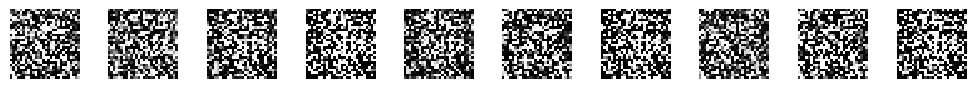

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt


# Define the generator
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

# Define the discriminator
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Define the combined GAN model
z = tf.keras.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = tf.keras.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer='adam')

# Training the GAN
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train / 127.5 - 1.0
X_train = np.expand_dims(X_train, axis=3)
batch_size = 64
epochs = 100
half_batch = batch_size // 2

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, 100))
    gen_imgs = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    valid_y = np.array([1] * batch_size)
    g_loss = combined.train_on_batch(noise, valid_y)

    if epoch % 1000 == 0:
        print(f"{epoch} [D loss: {d_loss[0]}] [G loss: {g_loss}]")


def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show()

plot_generated_images(epochs, generator)


# **Autoencoders and Variational Autoencoders (VAEs)**
* Autoencoders compress data into a latent space and reconstruct it. VAEs add a probabilistic approach, ensuring a continuous latent space.

**Example:** Basic autoencoder for MNIST

Epoch 1/50
235/235 [==============================] - 3s 6ms/step - loss: 0.2437 - val_loss: 0.1669
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1499 - val_loss: 0.1360
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1313 - val_loss: 0.1253
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1232 - val_loss: 0.1193
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1173 - val_loss: 0.1132
Epoch 6/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1123 - val_loss: 0.1092
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.1088 - val_loss: 0.1061
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1065 - val_loss: 0.1041
Epoch 9/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1047 - val_loss: 0.1025
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1032 - val_loss: 0.1009

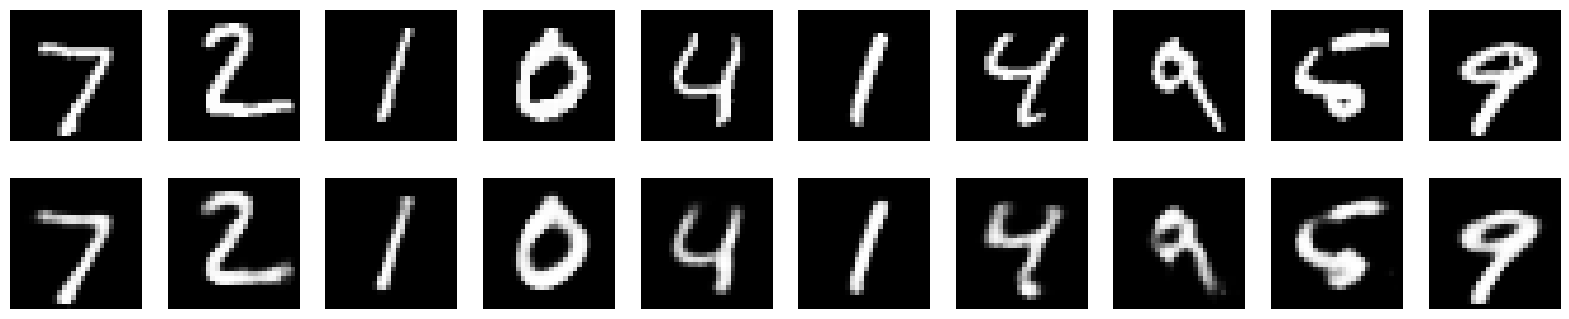

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the encoder
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# Define the decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

# Combine encoder and decoder into an autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Create the encoder model
encoder = Model(input_img, encoded) # Create the encoder model

# Load and preprocess the dataset
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

encoded_imgs = encoder.predict(X_test) # Now you can use the encoder model
decoded_imgs = autoencoder.predict(X_test)

n = 10  # Number of digits to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')
plt.show()

**Variational Autoencoder Example:**



In [16]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define the encoder
input_img = Input(shape=(784,))
h = Dense(128, activation='relu')(input_img)
z_mean = Dense(2)(h)
z_log_var = Dense(2)(h)

z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

# Define the decoder
decoder_h = Dense(128, activation='relu')
decoder_mean = Dense(784, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Define the VAE model
vae = Model(input_img, x_decoded_mean)

# Define the loss
def vae_loss(x, x_decoded_mean):
    xent_loss = tf.keras.backend.binary_crossentropy(x, x_decoded_mean) # Use tf.keras.backend.binary_crossentropy
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss) # Calculate mean of the sum of losses

vae.compile(optimizer='adam', loss=vae_loss)

# Train the VAE
# vae.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))


# **Attention Mechanism**
* Attention mechanisms allow models to focus on relevant parts of the input sequence, crucial in tasks like machine translation.

**Example:** Attention in Seq2Seq model

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention

# Define the encoder
encoder_inputs = Input(shape=(None, 128))
encoder_lstm = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# Define the decoder with attention
decoder_inputs = Input(shape=(None, 128))
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])

# Apply attention
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, attention])

# Define the output layer
decoder_dense = Dense(128, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
# model.fit([encoder_input_data, decoder_input_data], decoder_target_data, epochs=100)


# **Transformer**
* Transformers are a type of model architecture that relies entirely on self-attention mechanisms and is widely used in NLP tasks.

**Example:** Transformer for text classification

Epoch 1/10
4/4 [==============================] - 6s 203ms/step - loss: 3.2088 - accuracy: 0.0700 - val_loss: 3.3486 - val_accuracy: 0.0500
Epoch 2/10
4/4 [==============================] - 0s 46ms/step - loss: 2.0984 - accuracy: 0.3800 - val_loss: 3.2762 - val_accuracy: 0.1000
Epoch 3/10
4/4 [==============================] - 0s 16ms/step - loss: 1.3016 - accuracy: 0.8800 - val_loss: 3.3743 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 17ms/step - loss: 0.7105 - accuracy: 1.0000 - val_loss: 3.4198 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 23ms/step - loss: 0.3351 - accuracy: 1.0000 - val_loss: 3.3805 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 16ms/step - loss: 0.1404 - accuracy: 1.0000 - val_loss: 3.3309 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 49ms/step - loss: 0.0705 - accuracy: 1.0000 - val_loss: 3.3001 - val_accuracy: 0.0500
Epoch 8/10

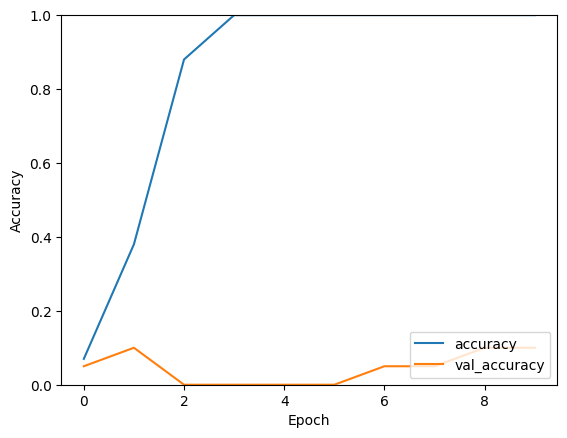

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Define the transformer block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    attn_output = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output + inputs)
    ffn_output = Dense(ff_dim, activation='relu')(attn_output)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attn_output)
    return ffn_output

# Define the transformer model
inputs = Input(shape=(None,))
x = Embedding(input_dim=20000, output_dim=128)(inputs)
x = transformer_block(x, head_size=128, num_heads=4, ff_dim=128, dropout=0.1)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
outputs = Dense(20, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create some dummy data for demonstration purposes
import numpy as np
x_train = np.random.randint(20000, size=(100, 10))  # Replace with your actual training data
y_train = np.random.randint(20, size=(100,))  # Replace with your actual training labels
x_val = np.random.randint(20000, size=(20, 10))    # Replace with your actual validation data
y_val = np.random.randint(20, size=(20,))      # Replace with your actual validation labels

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

import matplotlib.pyplot as plt

# Assuming 'history' is obtained from model.fit()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# **Distributed Training**
* Distributed training refers to training deep learning models across multiple devices (GPUs, TPUs) or machines. This approach helps in reducing training time by distributing the computation load.

**Key Points:**

* Enhances training efficiency and scalability.
* Two main strategies: Data Parallelism and Model Parallelism.
* TensorFlow 2.0 provides tf.distribute API to simplify distributed training.

# **Using TensorFlow tf.distribute API**
* The tf.distribute API in TensorFlow 2.0 provides a high-level interface for distributed training, making it easier to distribute models and training across multiple devices and machines.


**Key Points:**

* tf.distribute.Strategy is the main class.
* Common strategies include MirroredStrategy, TPUStrategy, MultiWorkerMirroredStrategy, and CentralStorageStrategy.
* Simplifies the implementation of both data and model parallelism.


# **Data Parallelism**
* Data parallelism involves splitting the training data across multiple devices and each device trains a copy of the model on a subset of the data. Gradients are then averaged and updated synchronously.

**Key Points:**

* Each device processes a different portion of the data.
* Common approach for multi-GPU training.
* Synchronization of gradients is crucial to ensure model consistency.


**Example: Using tf.distribute.MirroredStrategy for data parallelism**




In [1]:
import tensorflow as tf

# Create a MirroredStrategy
strategy = tf.distribute.MirroredStrategy()

# Define the model inside the strategy scope
with strategy.scope():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Create a distributed dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

# Define the training step function
@tf.function
def train_step(inputs):
    def step_fn(inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss
    per_replica_losses = strategy.run(step_fn, args=(inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

# Training loop
for epoch in range(10):
    total_loss = 0.0
    num_batches = 0
    for batch in train_dist_dataset:
        total_loss += train_step(batch)
        num_batches += 1
    train_loss = total_loss / num_batches
    print(f'Epoch {epoch + 1}, Loss: {train_loss}')


# **Model Parallelism**
* Model parallelism involves splitting the model itself across multiple devices, where different layers or operations run on different devices. This is beneficial for very large models that cannot fit into the memory of a single device.

**Key Points:**

* Useful for very large models.
* Requires careful design to manage dependencies between model parts.
* Can be more complex to implement compared to data parallelism.

**Example: Manual model parallelism**

In [3]:
import tensorflow as tf

# Manually assign different parts of the model to different devices
with tf.device('/GPU:0'):
    input_layer = tf.keras.layers.Input(shape=(28,28)) # Change input shape to (28,28)
    flatten = tf.keras.layers.Flatten()(input_layer) # Add a Flatten layer
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(flatten)

with tf.device('/GPU:1'):
    dense_2 = tf.keras.layers.Dense(64, activation='relu')(dense_1)
    output_layer = tf.keras.layers.Dense(10, activation='softmax')(dense_2)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
938/938 [==============================] - 5s 3ms/step - loss: 0.2793 - accuracy: 0.9179
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1147 - accuracy: 0.9658
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0801 - accuracy: 0.9751
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0597 - accuracy: 0.9814
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0470 - accuracy: 0.9850
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0388 - accuracy: 0.9875
Epoch 7/10
938/938 [==============================] - 3s 4ms/step - loss: 0.0320 - accuracy: 0.9900
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0258 - accuracy: 0.9918
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0221 - accuracy: 0.9926
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0174 - accuracy: 0.9943

# **Model Optimization and Deployment in TensorFlow 2.0**

**Model Optimization:**
* Model optimization refers to techniques used to enhance the performance of a machine learning model, making it more efficient in terms of speed, memory usage, and power consumption.

**Deployment:**
* Model deployment is the process of making a trained machine learning model available for use in a production environment.

# **Model Optimization and Deployment Techniques**

**Key Techniques:**

* **Quantization:** Reducing the precision of the model's weights and activations.
* **Pruning:** Removing unnecessary weights from the model.
* **Mixed Precision Training:** Using both 16-bit and 32-bit floating-point types during training.
* **Weight Clustering:** Grouping weights into clusters to reduce the number of unique weight values.

**Example: Combining techniques**

In [4]:
!pip install tensorflow_model_optimization
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity

# Define a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Quantization-aware training
quant_aware_model = tf.keras.models.clone_model(model)
quant_aware_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Pruning parameters
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.90, begin_step=0, end_step=1000)
}
pruned_model = sparsity.prune_low_magnitude(model, **pruning_params)
pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load dataset  # Load the MNIST dataset here
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0  # Reshape and normalize
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0    # Reshape and normalize

# Train and save pruned model
callbacks = [sparsity.UpdatePruningStep()]
pruned_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks)
model_stripped = sparsity.strip_pruning(pruned_model)
model_stripped.save('optimized_model.h5')

Epoch 1/10
1875/1875 [==============================] - 17s 7ms/step - loss: 0.3940 - accuracy: 0.8904 - val_loss: 0.2296 - val_accuracy: 0.9330
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2097 - accuracy: 0.9385 - val_loss: 0.1796 - val_accuracy: 0.9437
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1703 - accuracy: 0.9498 - val_loss: 0.1545 - val_accuracy: 0.9517
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1453 - accuracy: 0.9572 - val_loss: 0.1412 - val_accuracy: 0.9573
Epoch 5/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1272 - accuracy: 0.9618 - val_loss: 0.1284 - val_accuracy: 0.9616
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1133 - accuracy: 0.9653 - val_loss: 0.1220 - val_accuracy: 0.9620
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1022 - accuracy: 0.9690 - val_loss: 0.1145 - val_a

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Pruning**

* Pruning involves removing less important weights from a neural network, reducing the model's complexity without significantly impacting accuracy.

**Example: Pruning with TensorFlow Model Optimization Toolkit**

In [2]:
!pip install tensorflow_model_optimization
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity

# Define a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Define pruning parameters
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.30, final_sparsity=0.70, begin_step=2000, end_step=6000)
}

# Apply pruning
pruned_model = sparsity.prune_low_magnitude(model, **pruning_params)
pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load dataset  # Load the MNIST dataset here
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0  # Reshape and normalize
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0    # Reshape and normalize

# Train and save the pruned model
callbacks = [sparsity.UpdatePruningStep()]  # Add the callback here
pruned_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=callbacks)
model_stripped = sparsity.strip_pruning(pruned_model)
model_stripped.save('pruned_model.h5')


Epoch 1/10
1875/1875 [==============================] - 12s 5ms/step - loss: 0.2325 - accuracy: 0.9316 - val_loss: 0.1141 - val_accuracy: 0.9640
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0933 - accuracy: 0.9720 - val_loss: 0.0821 - val_accuracy: 0.9752
Epoch 3/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0640 - accuracy: 0.9806 - val_loss: 0.0666 - val_accuracy: 0.9793
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0453 - accuracy: 0.9863 - val_loss: 0.0645 - val_accuracy: 0.9805
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0366 - accuracy: 0.9883 - val_loss: 0.0682 - val_accuracy: 0.9795
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0301 - accuracy: 0.9911 - val_loss: 0.0662 - val_accuracy: 0.9801
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0253 - accuracy: 0.9922 - val_loss: 0.0685 - val_accura

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Mixed Precision Training**
* Mixed precision training uses both 16-bit (half precision) and 32-bit (single precision) floating-point types during model training. This can significantly speed up training and reduce memory usage on compatible hardware (like NVIDIA GPUs with Tensor Cores).

**Example: Mixed precision training with TensorFlow**

In [3]:
import tensorflow as tf

# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Define a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax', dtype='float32')  # Use float32 for final layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7d5e67a3ca90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7d5e67a3ca90>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1875/1875 [==============================] - 112s 55ms/step - loss: 0.2451 - accuracy: 0.9284 - val_loss: 0.1237 - val_accuracy: 0.9613
Epoch 2/10
1875/1875 [==============================] - 98s 52ms/step - loss: 0.1043 - accuracy: 0.9687 - val_loss: 0.0958 - val_accuracy: 0.9699
Epoch 3/10
1875/1875 [==============================] - 93s 49ms/step - loss: 0.0740 - accuracy: 0.9770 - val_loss: 0.0833 - val_accuracy: 0.9732
Epoch 4/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.0537 - accuracy: 0.9836 - val_loss: 0.0961 - val_accuracy: 0.9717
Epoch 5/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.0438 - accuracy: 0.9857 - val_loss: 0.0762 

# **TensorFlow Serving for Model Deployment**
* TensorFlow Serving is a flexible, high-performance serving system for machine learning models designed for production environments.



**Example: Serving a TensorFlow model**

**1-Save the model in the SavedModel format:**

In [ ]:
model.save('saved_model/1/')

**2-Start TensorFlow Serving:**

In [ ]:
docker pull tensorflow/serving
docker run -p 8501:8501 --name=tf_serving --mount type=bind,source=$(pwd)/saved_model,target=/models/my_model -e MODEL_NAME=my_model -t tensorflow/serving

**3-Make predictions using the REST API:**

In [ ]:
import requests
import json
import numpy as np

data = json.dumps({"signature_name": "serving_default", "instances": x_test[:5].tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/my_model:predict', data=data, headers=headers)
predictions = np.array(json.loads(json_response.text)["predictions"])
print(predictions)


# **1. What is a Custom Layer?**

* A custom layer in TensorFlow is a user-defined layer that extends the base functionality provided by TensorFlow's existing layers. Custom layers allow you to implement and encapsulate specific operations or logic that are not available in the standard library.

# **2. Writing Custom Layers**
* To write a custom layer in TensorFlow, you need to subclass the tf.keras.layers.Layer class and implement the build and call methods.

**Example: Creating a Custom Layer**

* This example demonstrates creating a custom dense layer with a custom activation function.

In [4]:
import tensorflow as tf

class CustomDenseLayer(tf.keras.layers.Layer):
    def __init__(self, units=32, activation=None):
        super(CustomDenseLayer, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        z = tf.matmul(inputs, self.w) + self.b
        if self.activation is not None:
            return self.activation(z)
        return z

# Usage example
model = tf.keras.Sequential([
    CustomDenseLayer(64, activation='relu'),
    CustomDenseLayer(10)
])

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# **3. Writing Custom Models**
* To create a custom model, you need to subclass the tf.keras.Model class and define the __init__ and call methods.

**Example: Creating a Custom Model**

* This example demonstrates creating a custom model that uses the custom dense layer defined above.



In [5]:
class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.layer1 = CustomDenseLayer(64, activation='relu')
        self.layer2 = CustomDenseLayer(10)

    def call(self, inputs):
        x = self.layer1(inputs)
        return self.layer2(x)

# Usage example
model = CustomModel()

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# **4. Custom Training Loops with tf.GradientTape**
* TensorFlow 2.0 provides the tf.GradientTape API for more control over the training loop, allowing for custom training workflows.

**Example: Custom Training Loop**

* This example demonstrates a custom training loop using tf.GradientTape.

In [7]:
import tensorflow as tf

class CustomDenseLayer(tf.keras.layers.Layer):
    def __init__(self, units=32, activation=None):
        super(CustomDenseLayer, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)

    def call(self, inputs):
        z = tf.matmul(inputs, self.w) + self.b
        if self.activation is not None:
            return self.activation(z)
        return z

class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.layer1 = CustomDenseLayer(64, activation='relu')
        self.layer2 = CustomDenseLayer(10)
        # Add a flattening layer to reshape the input
        self.flatten = tf.keras.layers.Flatten()

    def call(self, inputs):
        x = self.flatten(inputs) # Flatten the input before passing to dense layers
        x = self.layer1(x)
        return self.layer2(x)

# Usage example
model = CustomModel()

# Compile and train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the loss function and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define metrics to track loss and accuracy
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(32)

# Training loop
EPOCHS = 5

for epoch in range(EPOCHS):
    for images, labels in train_dataset:
        train_step(images, labels)

    print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}, Accuracy: {train_accuracy.result() * 100}')
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch 1, Loss: nan, Accuracy: 10.336666107177734
Epoch 2, Loss: nan, Accuracy: 9.87166690826416
Epoch 3, Loss: nan, Accuracy: 9.87166690826416
Epoch 4, Loss: nan, Accuracy: 9.87166690826416
Epoch 5, Loss: nan, Accuracy: 9.87166690826416


# **1. Introduction to TFX (TensorFlow Extended)**

* TensorFlow Extended (TFX) is an end-to-end platform for deploying production machine learning (ML) pipelines. It provides a comprehensive set of components and libraries to integrate all the steps in the ML lifecycle, from data ingestion, data validation, and model training to model evaluation, model analysis, and model serving.

**Components of TFX:**

* **TensorFlow Data Validation (TFDV):** For data validation.
* **TensorFlow Transform (TFT):** For data preprocessing.
* **TensorFlow Model Analysis (TFMA):** For model evaluation.
* **TensorFlow Serving:** For model deployment.

# **2. Data Validation**
* **TensorFlow Data Validation (TFDV):**
* TFDV is a library for exploring and validating machine learning data. It allows you to understand the characteristics of your data and ensure it meets the requirements of your ML pipeline.

**Example: Using TFDV for Data Validation**

In [3]:
!pip install tensorflow_data_validation
import tensorflow_data_validation as tfdv

!pip install tensorflow_data_validation
import tensorflow_data_validation as tfdv
import pandas as pd
from sklearn.datasets import load_iris

# Load the iris dataset as a pandas DataFrame
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Save the DataFrame to a CSV file
df.to_csv('iris_data.csv', index=False)

# Generate statistics from the CSV file
stats = tfdv.generate_statistics_from_csv(data_location='iris_data.csv')

# Infer schema from statistics
schema = tfdv.infer_schema(stats)

# Display the schema
tfdv.display_schema(schema)

# Generate statistics from data
stats = tfdv.generate_statistics_from_csv(data_location='iris_data.csv')

# Infer schema from statistics
schema = tfdv.infer_schema(stats)

# Display the schema
tfdv.display_schema(schema)

# Validate statistics against the schema
anomalies = tfdv.validate_statistics(stats, schema)

# Display anomalies
tfdv.display_anomalies(anomalies)


,Type,Presence,Valency,Domain
Feature name,,,,
'sepal length (cm)',FLOAT,required,,-
'sepal width (cm)',FLOAT,required,,-
'petal length (cm)',FLOAT,required,,-
'petal width (cm)',FLOAT,required,,-
'target',INT,required,,-


,Type,Presence,Valency,Domain
Feature name,,,,
'sepal length (cm)',FLOAT,required,,-
'sepal width (cm)',FLOAT,required,,-
'petal length (cm)',FLOAT,required,,-
'petal width (cm)',FLOAT,required,,-
'target',INT,required,,-


# **3. Model Analysis**
* **TensorFlow Model Analysis (TFMA):**
 * TFMA is a library for evaluating TensorFlow models. It allows you to evaluate the performance of your models in a scalable and flexible way.

**Example: Using TFMA for Model Analysis**

In [19]:
# Install TensorFlow Model Analysis
# !pip install tensorflow_model_analysis

import tensorflow_model_analysis as tfma
import tensorflow as tf

# Convert CSV data to TFRecords
import pandas as pd
from sklearn.datasets import load_iris
import tempfile

# Load the iris dataset as a pandas DataFrame
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['label'] = iris.target  # Use 'label' as the label key

# Convert the 'label' column to integers
df['label'] = df['label'].astype(int)

# Save the DataFrame to a temporary CSV file
temp_csv = tempfile.NamedTemporaryFile(suffix='.csv', delete=False)
df.to_csv(temp_csv.name, index=False)

# Convert CSV to TFRecords
def to_tfrecords(csv_path, tfrecords_path):
    with tf.io.TFRecordWriter(tfrecords_path) as writer:
        for _, row in pd.read_csv(csv_path).iterrows():
            example = tf.train.Example(
                features=tf.train.Features(
                    feature={
                        'sepal length (cm)': tf.train.Feature(float_list=tf.train.FloatList(value=[row['sepal length (cm)']])),
                        'sepal width (cm)': tf.train.Feature(float_list=tf.train.FloatList(value=[row['sepal width (cm)']])),
                        'petal length (cm)': tf.train.Feature(float_list=tf.train.FloatList(value=[row['petal length (cm)']])),
                        'petal width (cm)': tf.train.Feature(float_list=tf.train.FloatList(value=[row['petal width (cm)']])),
                        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(row['label'])]))  # Cast label to int
                    }
                )
            )
            writer.write(example.SerializeToString())

# Create a temporary TFRecord file
temp_tfrecords = tempfile.NamedTemporaryFile(suffix='.tfrecords', delete=False)
to_tfrecords(temp_csv.name, temp_tfrecords.name)

# Define feature description for parsing the TFRecord file
feature_description = {
    'sepal length (cm)': tf.io.FixedLenFeature([], tf.float32),
    'sepal width (cm)': tf.io.FixedLenFeature([], tf.float32),
    'petal length (cm)': tf.io.FixedLenFeature([], tf.float32),
    'petal width (cm)': tf.io.FixedLenFeature([], tf.float32),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

# Create a parsing function
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

# Create a dataset from the TFRecord file
raw_dataset = tf.data.TFRecordDataset(temp_tfrecords.name)
parsed_dataset = raw_dataset.map(_parse_function)

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(4,)),  # Use appropriate input shape
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(df[iris.feature_names].values, df['label'].values, epochs=10, validation_split=0.2)

# Save the model to a temporary location
model_location = tempfile.mkdtemp()
model.save(model_location)

# Define the evaluation configuration
eval_config = tfma.EvalConfig(
    model_specs=[tfma.ModelSpec(label_key='label')],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=[
        tfma.MetricsSpec(
            metrics=[
                tfma.MetricConfig(class_name='ExampleCount'),
                tfma.MetricConfig(class_name='Accuracy')
            ]
        )
    ]
)

# Modify the evaluation code to properly handle the parsed data
def serving_input_receiver_fn():
    feature_spec = {
        'sepal length (cm)': tf.io.FixedLenFeature([], tf.float32),
        'sepal width (cm)': tf.io.FixedLenFeature([], tf.float32),
        'petal length (cm)': tf.io.FixedLenFeature([], tf.float32),
        'petal width (cm)': tf.io.FixedLenFeature([], tf.float32)
    }
    serialized_tf_example = tf.compat.v1.placeholder(dtype=tf.string, shape=[None], name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    features = tf.io.parse_example(serialized_tf_example, feature_spec)
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

# Create the eval shared model
eval_shared_model = tfma.default_eval_shared_model(
    eval_saved_model_path=model_location,
    eval_config=eval_config,
    tags=[tf.saved_model.SERVING]
)

# Run the model analysis using the TFRecord file
eval_result = tfma.run_model_analysis(
    eval_shared_model=eval_shared_model,
    data_location=temp_tfrecords.name,  # Use the TFRecord file
    eval_config=eval_config
)

# Visualize the results
tfma.view.render_slicing_metrics(eval_result)

# Clean up temporary files
temp_csv.close()
temp_tfrecords.close()
import os
os.remove(temp_csv.name)
os.remove(temp_tfrecords.name)


Epoch 1/10
4/4 [==============================] - 3s 184ms/step - loss: 1.0300 - accuracy: 0.4167 - val_loss: 1.4689 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 0s 44ms/step - loss: 0.8791 - accuracy: 0.6917 - val_loss: 1.3620 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 0s 45ms/step - loss: 0.7862 - accuracy: 0.8333 - val_loss: 1.1471 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 0s 52ms/step - loss: 0.7054 - accuracy: 0.8333 - val_loss: 1.1261 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 0s 47ms/step - loss: 0.6302 - accuracy: 0.8333 - val_loss: 1.0930 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 0s 60ms/step - loss: 0.5620 - accuracy: 0.8333 - val_loss: 1.0834 - val_accuracy: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 0s 73ms/step - loss: 0.5044 - accuracy: 0.8333 - val_loss: 1.0809 - val_accuracy: 0.0000e+0

              the inputs are:
 [b'\n\x8a\x01\n\x1d\n\x11sepal length (cm)\x12\x08\x12\x06\n\x0433\xa3@\n\x1d\n\x11petal length (cm)\x12\x08\x12\x06\n\x0433\xb3?\n\x1c\n\x10sepal width (cm)\x12\x08\x12\x06\n\x04\x00\x00`@\n\x1c\n\x10petal width (cm)\x12\x08\x12\x06\n\x04\xcd\xccL>\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00'].
              The input_specs are:
 {'dense_12_input': TensorSpec(shape=(None, 4), dtype=tf.float32, name='dense_12_input')}.. Attempting to run batch through serially. Note that this will significantly affect the performance.
ERROR:apache_beam.runners.common:Fail to call signature func with signature_name: serving_default.
              the inputs are:
 [b'\n\x8a\x01\n\x1d\n\x11sepal length (cm)\x12\x08\x12\x06\n\x0433\xa3@\n\x1d\n\x11petal length (cm)\x12\x08\x12\x06\n\x0433\xb3?\n\x1c\n\x10sepal width (cm)\x12\x08\x12\x06\n\x04\x00\x00`@\n\x1c\n\x10petal width (cm)\x12\x08\x12\x06\n\x04\xcd\xccL>\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00'].
              The in

ValueError: Fail to call signature func with signature_name: serving_default.
              the inputs are:
 [b'\n\x8a\x01\n\x1d\n\x11sepal length (cm)\x12\x08\x12\x06\n\x0433\xa3@\n\x1d\n\x11petal length (cm)\x12\x08\x12\x06\n\x0433\xb3?\n\x1c\n\x10sepal width (cm)\x12\x08\x12\x06\n\x04\x00\x00`@\n\x1c\n\x10petal width (cm)\x12\x08\x12\x06\n\x04\xcd\xccL>\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\x00'].
              The input_specs are:
 {'dense_12_input': TensorSpec(shape=(None, 4), dtype=tf.float32, name='dense_12_input')}. [while running 'ExtractEvaluateAndWriteResults/ExtractAndEvaluate/ExtractPredictions/Inference']

# **4. Model Serving**
**TensorFlow Serving:**
* TensorFlow Serving is a flexible, high-performance serving system for machine learning models designed for production environments.

**Example: Serving a TensorFlow Model**

1-Save the Model in the SavedModel Format:

In [ ]:
import tensorflow as tf

# Define and train a model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Save the model in the SavedModel format
model.save('saved_model/my_model')


2-Start TensorFlow Serving:

In [ ]:
docker pull tensorflow/serving
docker run -p 8501:8501 --name=tf_serving --mount type=bind,source=$(pwd)/saved_model,target=/models/my_model -e MODEL_NAME=my_model -t tensorflow/serving


3-Make Predictions Using the REST API:

In [ ]:
import requests
import json
import numpy as np

data = json.dumps({"signature_name": "serving_default", "instances": x_test[:5].tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/my_model:predict', data=data, headers=headers)
predictions = np.array(json.loads(json_response.text)["predictions"])
print(predictions)
